# Routing, speed imputation, and travel times

Including parallelized shortest-path solving via built-in multiprocessing in OSMnx.

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [27]:
import numpy as np
import osmnx as ox

%matplotlib inline
np.random.seed(0)
ox.__version__

'1.5.1'

In [28]:
place = "중구, 서울, 04537, 대한민국"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G)

## 1. Fast nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.

가장 가까운_노드 및 가장 가까운_가장자리 함수는 x 및 y(또는 lng/lat) 좌표의 배열을 가져와 각각에 가장 가까운 노드/가장자리를 반환합니다.

In [29]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [30]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(Gp, X, Y, return_dist=True)

In [31]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(Gp, X0, Y0)
node

3269944950

In [32]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.nearest_edges(Gp, X, Y, return_dist=True)

In [33]:
# find the nearest edge to a single point
edge = ox.nearest_edges(Gp, X0, Y0)
edge

(3269944950, 3269944951, 0)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

두 개의 노드를 선택합니다. 그런 다음 이동 거리를 최소화하여 최단 경로를 찾기 위해 weight='length'를 사용하여 출발지와 목적지 사이의 최단 경로를 찾습니다(그렇지 않으면 각 가장자리를 weight=1로 처리함).

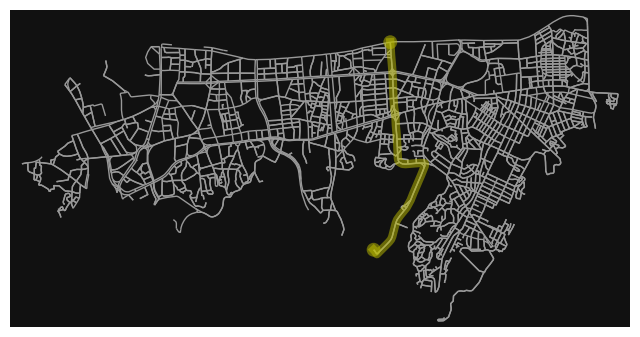

In [34]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[120]
route = ox.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

Or get *k* shortest paths, weighted by some attribute:
또는 *k* 최단 경로를 얻고 일부 속성에 의해 가중치가 부여됩니다.

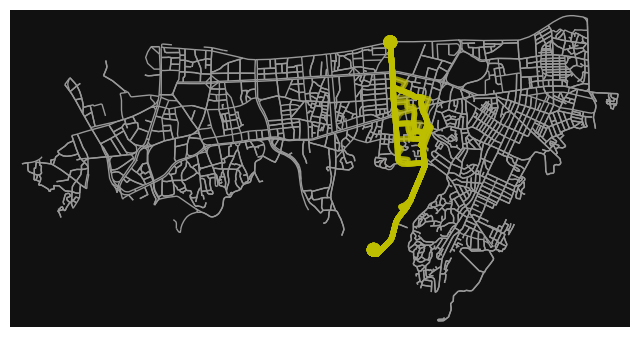

In [35]:
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="y", route_linewidth=4, node_size=0)

## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

`add_edge_speeds` 기능은 새로운 `speed_kph` 에지 속성으로 그래프에 에지 속도(시간당 km)를 추가합니다. 고속도로 유형별로 가장자리의 평균 'maxspeed' 값을 기준으로 모든 가장자리의 자유 흐름 이동 속도를 귀속합니다. 이 평균 전가는 분명히 부정확할 수 있으며 호출자는 로컬 속도 제한 표준에 해당하는 `hwy_speeds` 및/또는 `fallback` 인수를 전달하여 이를 재정의할 수 있습니다. 자세한 내용은 독스트링을 참조하십시오.

In [36]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [37]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",121.0,44.1,9.9
"['residential', 'living_street']",121.0,30.0,14.6
"['secondary_link', 'secondary']",172.0,44.1,14.0
living_street,22.1,44.1,1.8
primary,84.0,60.0,5.0
primary_link,59.8,44.1,4.9
residential,61.1,30.0,7.3
secondary,66.7,56.3,4.3
secondary_link,60.9,44.1,5.0


In [38]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [39]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

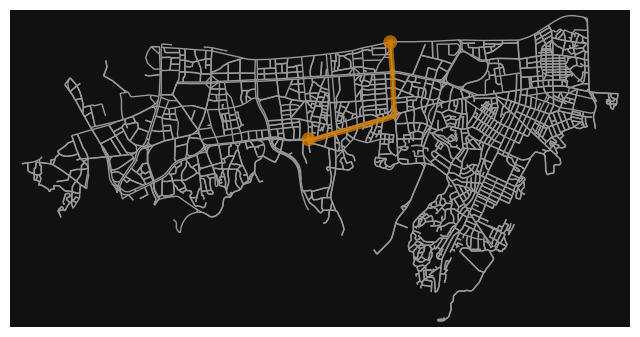

In [40]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [41]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.route_to_gdf(G, route1, "length")["length"]))
route2_length = int(sum(ox.utils_graph.route_to_gdf(G, route2, "length")["length"]))
route1_time = int(sum(ox.utils_graph.route_to_gdf(G, route1, "travel_time")["travel_time"]))
route2_time = int(sum(ox.utils_graph.route_to_gdf(G, route2, "travel_time")["travel_time"]))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 1574 meters and takes 113 seconds.
Route 2 is 1574 meters and takes 113 seconds.


The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](12-node-elevations-edge-grades.ipynb).

노란색 경로는 이동 시간을 최소화하므로 빨간색 경로보다 길지만 빠릅니다.

이동 시간에 대한 더 많은 예는 [isochrones 예](13-isolines-isochrones.ipynb)를 참조하세요.

고도를 임피던스로 사용하는 것을 포함하여 라우팅에 대한 더 많은 예는 [고도 예시](12-node-elevations-edge-grades.ipynb)를 참조하세요.

## 4. Multiprocessing

Calculating lots of shortest paths can be slow, but OSMnx has built-in shortest path solver parallelization and multiprocessing. With the `shortest_path` function, you can pass in a single origin-destination pair to solve the one shortest path, or you can pass in lists of origins and destinations to solve each shortest path between the pairs. If you're solving shortest paths for multiple origins/destinations, the `cpus` argument determines how many CPU cores to utilize for parallelized solving. Multiprocessing adds some overhead, so it's only faster if you're solving a lot of paths. It also has substantial RAM requirements (as it must copy the graph into each sub-process), so be carefuly with your RAM when setting the `cpus` argument.

In [42]:
# calculate 100,000 shortest-path routes using random origin-destination pairs
n = 100000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [43]:
%%time
# it takes 2.3 seconds to solve all the routes using all the cores on my computer
# I have a 24-thread AMD 5900x: performance will depend on your specific CPU
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=None)

CPU times: total: 4.2 s
Wall time: 3min 39s


In [44]:
%%time
# it takes 29 seconds to solve all the routes using just 1 core on my computer
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

CPU times: total: 7min 40s
Wall time: 7min 54s


In [45]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

100000
98691


## 5. Miscellaneous routing notes

The routing correctly handles one-way streets:

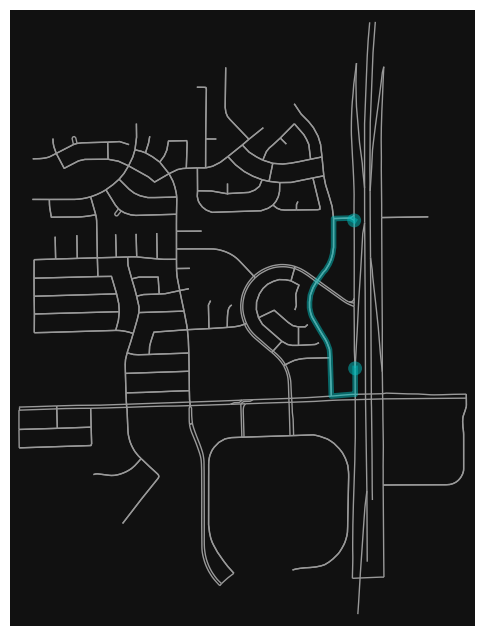

In [52]:
G2 = ox.graph_from_address(
    "N. Sicily Pl., Chandler, Arizona",
    dist=800,
    network_type="drive",
    truncate_by_edge=True,
)
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)

Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

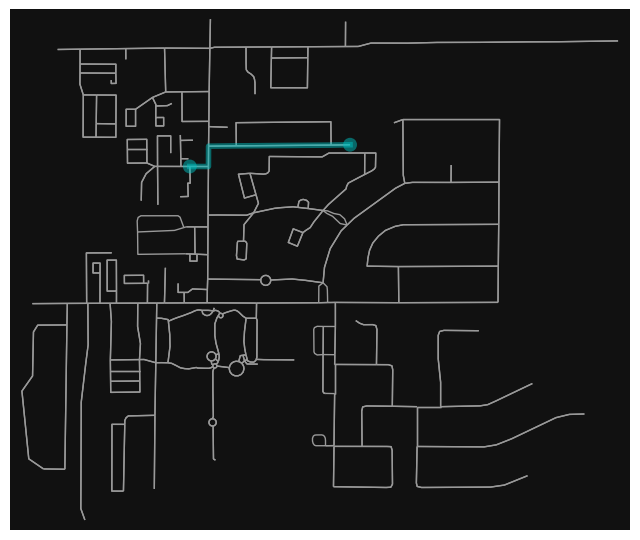

In [53]:
location_point = (33.299896, -111.831638)
G2 = ox.graph_from_point(location_point, dist=400, truncate_by_edge=True)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)